In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 58.5MB/s]


In [7]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
!unzip *.zip && rm -rf *.zip

In [8]:
batch_size=8
img_width = 38
img_height = 38

In [9]:
dataset_path = "/content/CK+48"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation"
)

Found 981 files belonging to 7 classes.
Using 785 files for training.
Found 981 files belonging to 7 classes.
Using 196 files for validation.


In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'] 7


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [13]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 38, 38, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 38, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)         

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
checkpointer = ModelCheckpoint(filepath="face_emotions.hdf5",
                               verbose=1, save_best_only=True)

num_epochs = 100
history = model.fit(
    train_ds,
    epochs=num_epochs,
    callbacks=[checkpointer],
    validation_data=validation_ds,
    verbose=1
)

Epoch 1/100
99/99 [==============================] - 31s 12ms/step - loss: 1.8565 - accuracy: 0.2331 - val_loss: 1.8062 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.80617, saving model to face_emotions.hdf5
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 1.5567 - accuracy: 0.3592 - val_loss: 1.3202 - val_accuracy: 0.4541

Epoch 00002: val_loss improved from 1.80617 to 1.32022, saving model to face_emotions.hdf5
Epoch 3/100
99/99 [==============================] - 1s 8ms/step - loss: 1.3042 - accuracy: 0.4599 - val_loss: 1.2269 - val_accuracy: 0.4541

Epoch 00003: val_loss improved from 1.32022 to 1.22691, saving model to face_emotions.hdf5
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 1.2401 - accuracy: 0.4662 - val_loss: 1.1244 - val_accuracy: 0.5510

Epoch 00004: val_loss improved from 1.22691 to 1.12439, saving model to face_emotions.hdf5
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - los

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

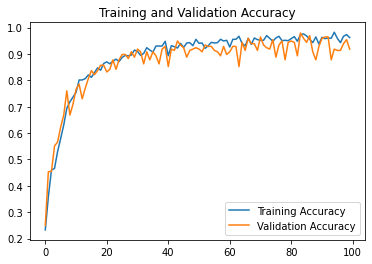

In [19]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

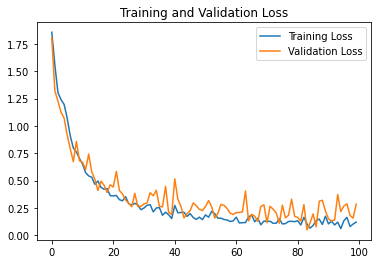

In [20]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

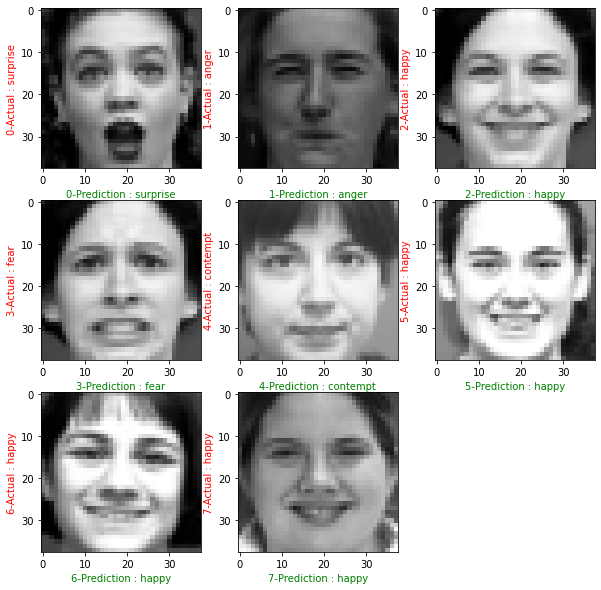

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in validation_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img_array = keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    plt.ylabel(f"{i}-Actual : {class_names[labels[i]]}")
    plt.xlabel(f"{i}-Prediction : {class_names[np.argmax(score)]}")
    ax.xaxis.label.set_color('green')
    ax.yaxis.label.set_color('red')